In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.layers import ReLU, Add
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import Model


In [ ]:
## unzips mnist

import sys
import gzip
import shutil
import os


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./')
                if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [ ]:
## unzips mnist

import sys
import gzip
import shutil
import os


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./')
                if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [4]:
import struct
import numpy as np

import sys
import gzip
import shutil
import os

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                                % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_data, y_data = load_mnist('/content/drive/MyDrive/Colab_Notebooks_2/data', kind='train')
print('Rows: %d,  Columns: %d' % (X_data.shape[0], X_data.shape[1]))
X_test, y_test = load_mnist('/content/drive/MyDrive/Colab_Notebooks_2/data', kind='t10k')
print('Rows: %d,  Columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('Training:   ', X_train.shape, y_train.shape)
print('Validation: ', X_valid.shape, y_valid.shape)
print('Test Set:   ', X_test.shape, y_test.shape)

Rows: 60000,  Columns: 784
Rows: 10000,  Columns: 784
Training:    (50000, 784) (50000,)
Validation:  (10000, 784) (10000,)
Test Set:    (10000, 784) (10000,)


In [5]:
# Standardize data based on training data
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_data, y_data, X_train, X_valid, X_test

# Chapter 15 - Classifying Images with Deep Convolutional Neural Networks

## Architectures
- Non-sequential network topology
    - Connections between non-neighbour layers (residual networks, skip-connections)
        - Possibly to all later layers (DenseNet)
    - Parallell filter groups, e.g. series of convoutions in parallel (e.g. Inception cells)
    - Extra input and/or output layers in the network
- Can be modular - blocks of convolutions used several times
- Keras Applications: pre-built, pre-trained
- Implementation requires `keras.Model` (Functional API)

```python
model = Sequential()
model.add(...)      
   ->               
x2 = ... (x1)       
x3 = ... (x2)       
x4 = ... (x2, x3)
```

### Keras' Functional API

In [4]:


# This returns a tensor
inputs = Input(shape=(784,)) # , dtype='int32', name='main_input')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.fit(data, labels)  # starts training

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


### Residual networks
Add activation from a layer to the pre-activation of a later layer.
<img src="./images/ResNet1.png" alt="Feature map" style="width: 400px;"/>

In [5]:
# Add a shortcut/residual to a network (ResNet)

inputs = Input(shape=(784,))

x = Dense(64, activation='relu')(inputs)
shortcut = x           # Branch out

x = Dense(32, activation='relu')(x)
x = Dense(64)(x)       # No activation

x = Add()([shortcut, x]) # Add outputs (Make sure sizes match up)
x = ReLU()(x)
predictions = Dense(10, activation='softmax')(x)

In [6]:
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

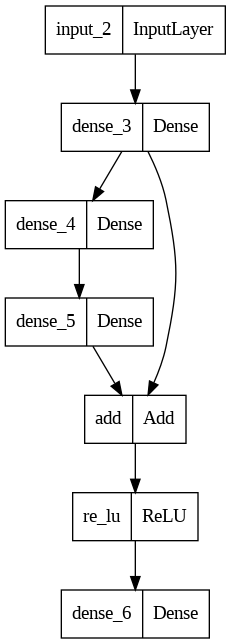

In [7]:
plot_model(model)

Implementation in Applications:
<img src="./images/ResNet.png" alt="Feature map" style="width: 800px;"/>

## Batch normalization
- Rescale activations to maintain mean and standard deviation close to 0 and 1.
- Especially useful for networks with many layers.
- Not fully understood why it has a positive effect.

**Example code of what a model definition could look like.**
```python
from tensorflow.keras.layers import BatchNormalization

inputs = Input(shape=(28,28,1))

x = inception_cell(inputs)
x = BatchNormalization()(x)
x = inception_cell(x)
x = BatchNormalization()(x)
x = inception_cell(x)
x = BatchNormalization()(x)
x = inception_cell(x)
x = BatchNormalization()(x)

predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
```

## Building on a pretrained network
- Reuse existing networks for new/tuned purposes
    - Called applications in Keras
- Main tasks of neural networks on images:
    - Generate meaningful features
    - Combine into objects
    - Distinguish between types of objects
- Strategy:
    - Strip final dense layer(s) (softmax)
    - Freeze network parameters
    - Train new dense layers for specific purpose

### Available networks in Keras (Tensorflow 2.6)
- Xception
- VGG16
- VGG19
- ResNet (50, 101, 152; v1, v2)
- Inception V3
- Inception ResNet V2
- MobileNet (v1, v2, v3Large, v3Small)
- DenseNet (121, 169, 201)
- NASNet (Large, Mobile)
- EfficientNet (B0, ..., B7)

### Let's test one before theorizing

In [13]:
from tensorflow.keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet', # Pre-trained on ImageNet data
                  include_top=False,        # Remove classification layer
                  input_shape=(28*3, 28*3, 1*3))  # IncpetionV3 requires at least 75x75 RGB
for layer in conv_base.layers:
    layer.trainable = False
conv_base.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 84, 84, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 41, 41, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 41, 41, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activatio

### Expand network

In [29]:
base_out = conv_base.output
base_out = Flatten()(base_out)
base_out = Dense(1024, activation='relu')(base_out)
base_out = Dropout(.5)(base_out)
base_out = Dense(10, activation='softmax')(base_out)
InceptionV3_model = Model(conv_base.input, base_out)

InceptionV3_model.compile(optimizer='adam',
          loss='categorical_crossentropy', 
          metrics=['accuracy'])

NameError: ignored

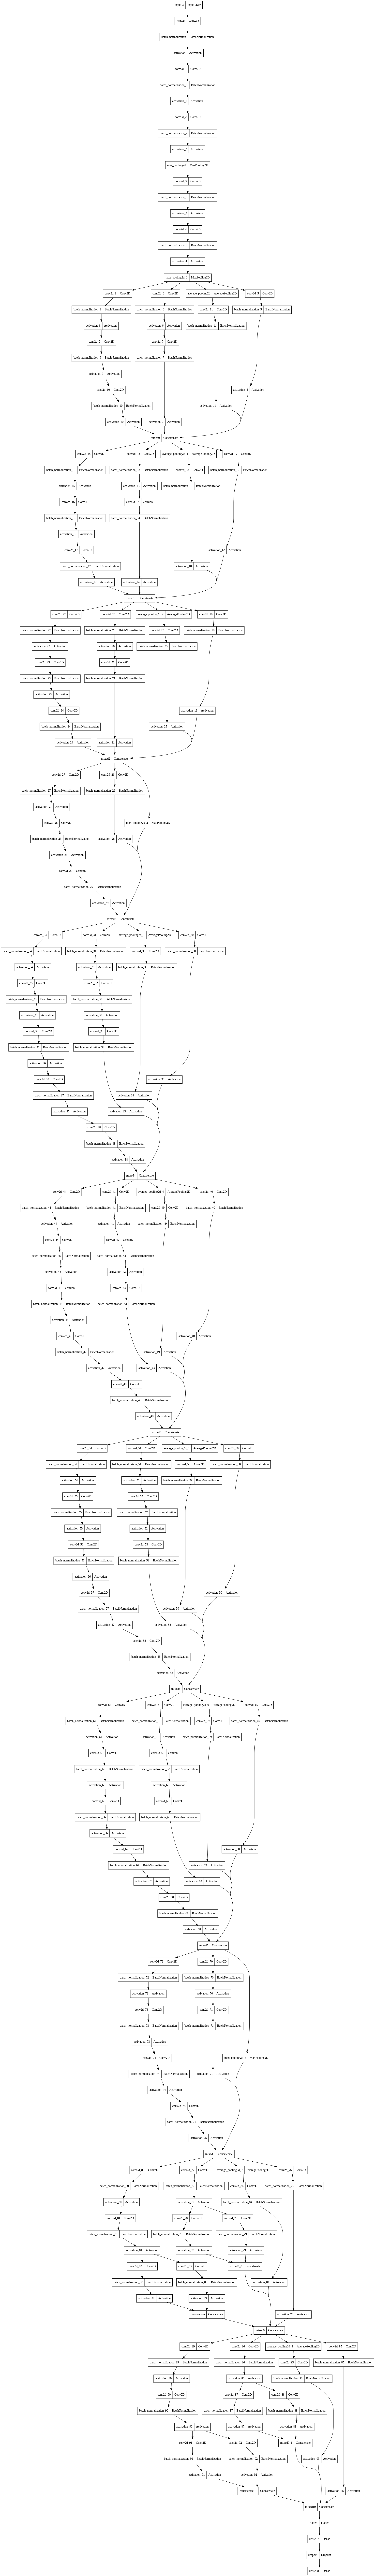

In [15]:
plot_model(InceptionV3_model)

In [6]:
from sklearn.preprocessing import OneHotEncoder #, LabelEncoder
#label_encoder = LabelEncoder()
#y_encoded = label_encoder.fit_transform(y_train)
one_hot_encoder = OneHotEncoder(sparse=False, categories='auto')
Y_train = one_hot_encoder.fit_transform(y_train.reshape(-1,1))
Y_valid = one_hot_encoder.transform(y_valid.reshape(-1,1))
Y_test  = one_hot_encoder.transform(y_test.reshape(-1,1))

X_train_centered = X_train_centered.reshape((X_train_centered.shape[0], 28, 28, 1)) # Grayscale = 1
X_valid_centered = X_valid_centered.reshape((X_valid_centered.shape[0], 28, 28, 1))
X_test_centered  = X_test_centered.reshape((X_test_centered.shape[0], 28, 28, 1))
print(X_train_centered.shape)
print(Y_train.shape)

(50000, 28, 28, 1)
(50000, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Update data generator with new size 


In [ ]:
# not enough resources in free colab for this
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0,
                            height_shift_range=0,
                            zoom_range=0,
                            rotation_range=1,
                            vertical_flip=False,
                            horizontal_flip=False)
datagen.fit(X_train_centered)
train_generator = datagen.flow(np.array(X_train_centered.repeat(3,1).repeat(3,2).repeat(3,3)), np.array(Y_train), # <-- Update
                               batch_size=64)

### Train InceptionV3 on MNIST
~ 7m/epoch on teacher's laptop  
Needs images to be at least 75x75, i.e. larger than MNIST's 28x28, therefore .repeat(3,x)

In [ ]:
# not enough resources in free colab for this
historyFlowInceptionV3 = InceptionV3_model.fit(
    train_generator,
    epochs=10, steps_per_epoch=len(X_train_centered) / 64,
    validation_data=(np.array(X_valid_centered.repeat(3,1).repeat(3,2).repeat(3,3)), np.array(Y_valid)), 
    validation_steps=len(X_valid_centered) / 64)

### Inception networks
- Inception cells / modules
    - Extract features on different scales, concatenate output
    - Use padding="same" to preserve sizes for concatenation
- Usually combined with bottlenecks to reduce channel depth (number of parameters)
  - Convolutional layers sum over input channels after convolution
<img src="./images/Inception_cell.png" alt="Inception cell" style="width: 600px;"/>

In [7]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

input_shape = X_train_centered.shape[1:]
n_classes = len(np.unique(y_train))

def inception_cell(x):
    # 1x1 convolution
    x1 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding="same", activation="relu")(x)

    # 1x1 + 3x3 convolution
    x3 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding="same", activation="relu")(x)
    x3 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x3)

    # 1x1 + 5x5 convolution
    x5 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding="same", activation="relu")(x)
    x5 = Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(x5)
    
    # MaxPool + 1x1 convolution
    xp = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding="same")(x)
    xp = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding="same", activation="relu")(xp)
 
    x = Concatenate()([x1, x3, x5, xp])
    return(x)
    
inputs = Input(shape=input_shape)

x = inception_cell(inputs)
x = inception_cell(x)
x = MaxPooling2D(pool_size=(5,5), padding="same")(x)
x = Flatten()(x)


predictions = Dense(n_classes, activation='softmax')(x)

In [10]:
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 32)   64          ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 32)   64          ['input_3[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 28, 28, 1)    0           ['input_3[0][0]']                
                                                                                            

In [12]:
history = model.fit(X_train_centered, Y_train, epochs=5, batch_size=32, verbose=1,
                    validation_data=(X_valid_centered, np.array(Y_valid)),
                    )

Epoch 1/5
1563/1563 [==============================] - 21s 7ms/step - loss: 0.1433 - accuracy: 0.9567 - val_loss: 0.0565 - val_accuracy: 0.9832
Epoch 2/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0510 - accuracy: 0.9842 - val_loss: 0.0505 - val_accuracy: 0.9863
Epoch 3/5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0370 - accuracy: 0.9884 - val_loss: 0.0468 - val_accuracy: 0.9875
Epoch 4/5
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0294 - accuracy: 0.9904 - val_loss: 0.0481 - val_accuracy: 0.9867
Epoch 5/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0234 - accuracy: 0.9923 - val_loss: 0.0475 - val_accuracy: 0.9878


In [5]:
import matplotlib.pyplot as plt

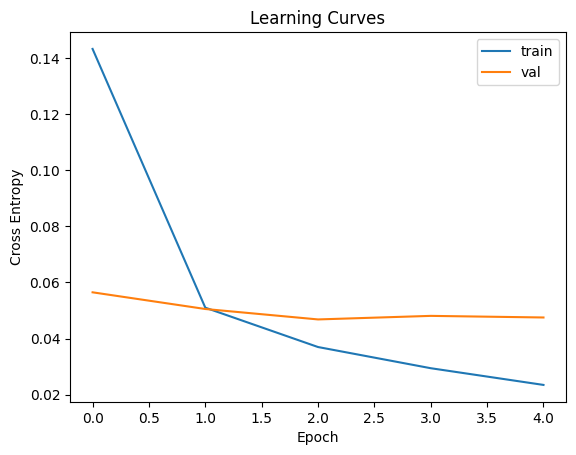

In [14]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [2]:
# class activity 3

import numpy as np
from keras.datasets import mnist
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from keras import backend as K

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Resize the images to 48x48 to match the input shape expected by VGG16
img_size = (48, 48)
x_train_resized = np.array([img_to_array(array_to_img(im, scale=False).resize(img_size)) for im in x_train])
x_test_resized = np.array([img_to_array(array_to_img(im, scale=False).resize(img_size)) for im in x_test])

# Load the VGG16 model (pretrained on ImageNet)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Create a new model
# add custom layers on top of the frozen model
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

# the first layer is the pretrained model
for layer in model.layers:
    print(layer)
# freeze it
model.layers[0].trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [3]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_resized, y_train, batch_size=128, epochs=10, validation_data=(x_test_resized, y_test))

Epoch 1/10
469/469 [==============================] - 33s 45ms/step - loss: 2.1589 - accuracy: 0.2165 - val_loss: 2.0858 - val_accuracy: 0.2483
Epoch 2/10
469/469 [==============================] - 17s 37ms/step - loss: 2.0142 - accuracy: 0.2766 - val_loss: 1.9776 - val_accuracy: 0.2906
Epoch 3/10
469/469 [==============================] - 17s 37ms/step - loss: 1.9483 - accuracy: 0.3001 - val_loss: 1.9454 - val_accuracy: 0.3012
Epoch 4/10
469/469 [==============================] - 17s 36ms/step - loss: 1.9106 - accuracy: 0.3154 - val_loss: 1.9575 - val_accuracy: 0.2838
Epoch 5/10
469/469 [==============================] - 17s 36ms/step - loss: 1.8841 - accuracy: 0.3216 - val_loss: 1.8865 - val_accuracy: 0.3240
Epoch 6/10
469/469 [==============================] - 17s 36ms/step - loss: 1.8631 - accuracy: 0.3307 - val_loss: 1.8590 - val_accuracy: 0.3349
Epoch 7/10
469/469 [==============================] - 17s 36ms/step - loss: 1.8433 - accuracy: 0.3408 - val_loss: 1.8509 - val_accuracy:

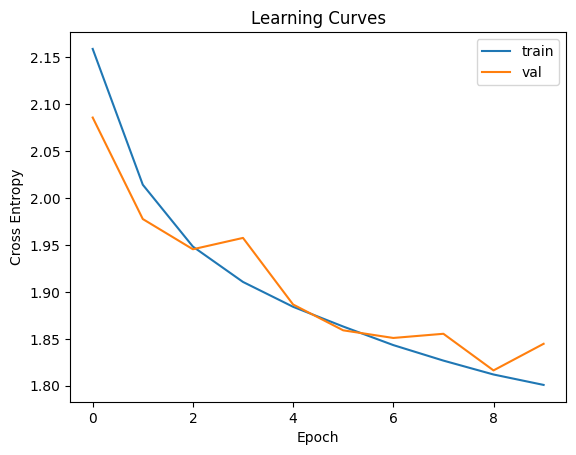

In [6]:

# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()